In [ ]:
# Latihan Machine Learning
# Import library yang dibutuhkan

In [ ]:
# Install Emoji
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 240 kB 6.2 MB/s 
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234927 sha256=bc63ebfba59ed28401ff12a07ee1a19f298903111f4213cc2a1d469d7a529445
  Stored in directory: /root/.cache/pip/wheels/f3/e3/f2/1de1c2e3ed742e1df73e0f15d58864e50c7e64f607b548d6cf
Successfully built emoji


In [ ]:
# Install Langdetect
!pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 981 kB 7.3 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993241 sha256=56545439b38d3f4356a5a2a33c8e3e274e3b97a9b882c49804ccde52e86a7216
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


In [ ]:
from textwrap import wrap

import emoji
import joblib
import langdetect
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

plt.style.use("fivethirtyeight")
warnings.filterwarnings("ignore")

In [ ]:
# Data Loading
def get_category_dict(category_file):
  category = pd.read_json(category_file, orient="records")
  category = pd.DataFrame(category["items"].values.tolist())

  return {
      cat.id: cat.snippet.get("title")
      for cat in category.itertuples(index=False)
  }

In [ ]:
category_dict = get_category_dict('/content/sample_data/category.json')

In [ ]:
trending = pd.read_csv("/content/sample_data/trending.csv", parse_dates=["publish_time", "trending_time"])
with pd.option_context("display.max_columns", None):
  display(trending.head())

,video_id,publish_time,channel_id,title,description,thumbnail_url,thumbnail_width,thumbnail_height,channel_name,tags,category_id,live_status,local_title,local_description,duration,dimension,definition,caption,license_status,allowed_region,blocked_region,view,like,dislike,favorite,comment,trending_time
0,NaN,2021-02-05 09:00:34+00:00,UCEf_Bc-KVd7onSeifS3py9g,aespa 에스파 'Forever (약속)' MV,"aespa's new single ""Forever"" is out!\nListen a...",NaN,NaN,NaN,SMTOWN,NaN,10,none,aespa 에스파 'Forever (약속)' MV,"aespa's new single ""Forever"" is out!\nListen a...",PT5M7S,2d,hd,True,True,NaN,NaN,7806846.0,857902.0,24078.0,0,94961.0,2021-02-07 05:46:51.832614+00:00
1,NaN,2021-02-04 15:54:08+00:00,UCYEa4_MC7OFjcWrO6SO-u8g,[FULL] Siapa di Balik Kudeta AHY? | Dua Sisi t...,"Jakarta, https://www.tvonenews.com - Ketua umu...",NaN,NaN,NaN,Indonesia Lawyers Club,"['tvone', 'tv one', 'tvonenews', 'indonesia la...",25,none,[FULL] Siapa di Balik Kudeta AHY? | Dua Sisi t...,"Jakarta, https://www.tvonenews.com - Ketua umu...",PT42M30S,2d,hd,False,True,NaN,NaN,885038.0,6765.0,1263.0,0,6365.0,2021-02-07 05:46:51.832649+00:00
2,NaN,2021-02-06 03:00:22+00:00,UCu12RxQjRQyh79YBYvEDkOg,CABRIOLET CHALLENGE: TANTANGAN MENGGODA (7/12),Road Party Season 2: Cabriolet Challenge\n\nEp...,NaN,NaN,NaN,Motomobi,"['MotoMobi', 'Mobil', 'motor', 'review', 'indo...",2,none,CABRIOLET CHALLENGE: TANTANGAN MENGGODA (7/12),Road Party Season 2: Cabriolet Challenge\n\nEp...,PT46M43S,2d,hd,False,True,NaN,NaN,889708.0,47895.0,532.0,0,8785.0,2021-02-07 05:46:51.832664+00:00
3,NaN,2021-02-05 20:26:08+00:00,UCCuzDCoI3EUOo_nhCj4noSw,With Windah Basudara & Hans,Join this channel to get access to perks:\nhtt...,NaN,NaN,NaN,yb,NaN,20,none,With Windah Basudara & Hans,Join this channel to get access to perks:\nhtt...,PT45M59S,2d,hd,False,True,NaN,NaN,1006854.0,91973.0,3967.0,0,12957.0,2021-02-07 05:46:51.832678+00:00
4,NaN,2021-02-03 23:14:54+00:00,UC14UlmYlSNiQCBe9Eookf_A,🤯 LATE COMEBACK DRAMA! | HIGHLIGHTS | Granada ...,"With just two minutes to play, Barça looked to...",NaN,NaN,NaN,FC Barcelona,"['FC Barcelona', 'برشلونة،', 'Fútbol', 'FUTBOL...",17,none,🤯 LATE COMEBACK DRAMA! | HIGHLIGHTS | Granada ...,"With just two minutes to play, Barça looked to...",PT5M12S,2d,hd,False,True,NaN,NaN,6275035.0,218131.0,4289.0,0,12799.0,2021-02-07 05:46:51.832730+00:00


In [ ]:
start_date = trending.trending_time.min()
end_date = trending.trending_time.max()

print("start_date =", start_date)
print("end_date =", end_date)

start_date = 2021-02-07 05:46:51.832614+00:00
end_date = 2022-11-20 06:01:46.358486+00:00


In [ ]:
# Delete data dari Februari - Juni
filtered_trending = trending[trending.trending_time.dt.month >= 7]

start_date = filtered_trending.trending_time.min()
end_date = filtered_trending.trending_time.max()

print("start_date = ", start_date)
print("end_date = ", end_date)

start_date =  2021-07-01 06:01:25.524449+00:00
end_date =  2022-11-20 06:01:46.358486+00:00


In [ ]:
num_videos = filtered_trending.shape[0]
print(f'{num_videos :}')

63918


In [ ]:
# Disribusi Missing Value
filtered_trending.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63918 entries, 21322 to 118950
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   video_id           32118 non-null  object             
 1   publish_time       63918 non-null  datetime64[ns, UTC]
 2   channel_id         63918 non-null  object             
 3   title              63918 non-null  object             
 4   description        61680 non-null  object             
 5   thumbnail_url      32118 non-null  object             
 6   thumbnail_width    32118 non-null  float64            
 7   thumbnail_height   32118 non-null  float64            
 8   channel_name       63918 non-null  object             
 9   tags               55640 non-null  object             
 10  category_id        63918 non-null  int64              
 11  live_status        63918 non-null  object             
 12  local_title        63918 non-null  object

In [ ]:
# Delete video dengan description kosong
filtered_trending.dropna(subset=["description"], inplace=True)

In [ ]:
# Exploratory Data Analysis
trending_by_date = filtered_trending.groupby(
 filtered_trending.trending_time.dt.date
)
num_trending_per_day = trending_by_date.trending_time.count()
print("Number of videos in trending per day:", num_trending_per_day.unique())

Number of videos in trending per day: [195 196 197 198 194 193 192 191 190 188 187 185 189 186 184 183 132 182
 181 179 176 172 155 144 149 148 141 140 131 129 145 167 163 157 156 175
 169 199 200]


In [ ]:
# Trending duration
trending_duration = filtered_trending.groupby("title").agg(
 trending_duration=pd.NamedAgg(column="trending_time", aggfunc="count"),
 trending_start_date=pd.NamedAgg(column="trending_time", aggfunc="min"),
 trending_last_date=pd.NamedAgg(column="trending_time", aggfunc="max")
).sort_values("trending_duration", ascending=False).reset_index()
trending_duration.head(10)

,title,trending_duration,trending_start_date,trending_last_date
0,Toleransi antar tetangga di Korea🇰🇷.. 🤦🏻‍♂️,37,2022-07-02 06:01:31.621606+00:00,2022-08-07 06:01:00.607651+00:00
1,"JEJE PENGHUNI STASIUN DUKUH ATAS, PERNAH CABUT...",37,2022-07-02 06:01:31.621150+00:00,2022-08-07 06:01:00.607537+00:00
2,"NEGO 1 GEROBAK SHAWARMA VIRAL DI TIKTOK, SAMPE...",36,2022-07-08 06:01:39.900318+00:00,2022-08-12 06:01:33.892049+00:00
3,SINGAPORE STREET FOOD #08,35,2022-07-02 06:01:31.621620+00:00,2022-08-06 06:02:02.694750+00:00
4,"Tantangin VYN Pake Franco, 1 Kali Kena Hook Da...",35,2022-07-01 06:01:38.284040+00:00,2022-08-04 06:02:04.519603+00:00
5,OPW ARES Sudah Tamat,35,2022-07-02 06:01:31.621296+00:00,2022-08-05 06:02:43.644196+00:00
6,Kok di Indonesia ada penjual Rawon yg lebih pi...,34,2022-07-02 06:01:31.621592+00:00,2022-08-04 06:02:04.519738+00:00
7,SELAMAT LEBARAN GUYS!!!,33,2022-07-11 06:00:59.413948+00:00,2022-08-12 06:01:33.891919+00:00
8,BORONG ISI KULKAS SAMA BABY SHARK!!!,32,2022-07-02 06:01:31.621266+00:00,2022-08-02 06:14:40.735514+00:00
9,gak bisa bahasa enggres,32,2022-07-01 06:01:38.284013+00:00,2022-08-01 06:01:08.899895+00:00


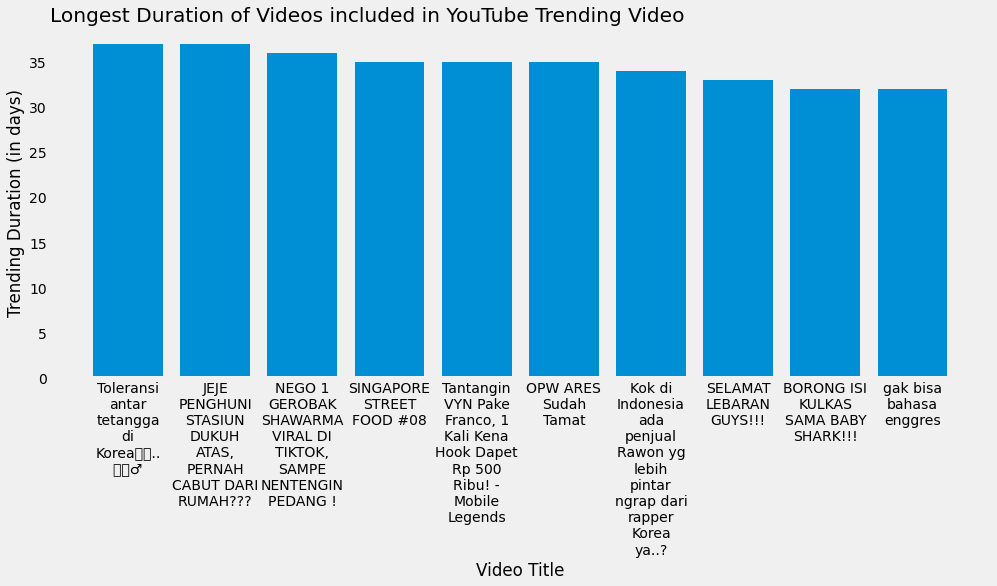

In [ ]:
# Visualisasi data trending dengan chart bar
plt.figure(figsize=(15, 6))
plt.bar(
 trending_duration.title[:10].apply(lambda title: "\n".join(wrap(title, width=10))),
 trending_duration.trending_duration[:10]
)
plt.title("Longest Duration of Videos included in YouTube Trending Video", loc="left")
plt.xlabel("Video Title")
plt.ylabel("Trending Duration (in days)")
plt.grid(False)
plt.show()

In [ ]:
# Most Viewed, Liked and Disliked Video
trending_by_title = filtered_trending.groupby("title")
trending_rewind = trending_by_title[["view", "like", "dislike"]].agg(["min", "max", "mean", "sum"])
trending_rewind

view             \
                                                          min        max   
title                                                                      
"Awalnya Diserang Bertubi tubi" Lihatlah Bagaim...   101823.0   121044.0   
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...  2280620.0  2637486.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...    72434.0   116310.0   
"Grebek rumah harris vriza, dan percintaannya d...    68879.0   163773.0   
"Hellevator" Band Cover By Xdinary Heroes (원곡 :...   393043.0  1348612.0   
...                                                       ...        ...   
🥘Yuk! Kita coba in! Let’s eat | WayV’s ONE-DAY ...   148668.0   680210.0   
🥰 New Gadgets & Versatile Utensils For Home # 2...   330156.0  7334655.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...   278942.0  1212522.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...   320084.0  1097903.0   
🩸괴담회에 어서오세요🩸: 첫 번째 이야기 | WELCOME TO NCT’S HORRO...  1423178.0  2966798.0   

                                                                              \
                                                            mean         sum   
title                                                                          
"Awalnya Diserang Bertubi tubi" Lihatlah Bagaim...  1.114335e+05    222867.0   
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...  2.459053e+06   4918106.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...  9.390625e+04    375625.0   
"Grebek rumah harris vriza, dan percintaannya d...  1.267565e+05    760539.0   
"Hellevator" Band Cover By Xdinary Heroes (원곡 :...  1.126182e+06  14640369.0   
...                                                          ...         ...   
🥘Yuk! Kita coba in! Let’s eat | WayV’s ONE-DAY ...  5.519997e+05   8831995.0   
🥰 New Gadgets & Versatile Utensils For Home # 2...  3.414214e+06  34142143.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...  7.948737e+05   5564116.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...  7.562497e+05   4537498.0   
🩸괴담회에 어서오세요🩸: 첫 번째 이야기 | WELCOME TO NCT’S HORRO...  2.629831e+06  36817634.0   

                                                        like            \
                                                         min       max   
title                                                                    
"Awalnya Diserang Bertubi tubi" Lihatlah Bagaim...    1336.0    1456.0   
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...   93348.0  101207.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...     990.0    1432.0   
"Grebek rumah harris vriza, dan percintaannya d...    5529.0    8714.0   
"Hellevator" Band Cover By Xdinary Heroes (원곡 :...  127824.0  262846.0   
...                                                      ...       ...   
🥘Yuk! Kita coba in! Let’s eat | WayV’s ONE-DAY ...   39847.0  101922.0   
🥰 New Gadgets & Versatile Utensils For Home # 2...    2822.0   58066.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...    2790.0   10212.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...    3025.0    8759.0   
🩸괴담회에 어서오세요🩸: 첫 번째 이야기 | WELCOME TO NCT’S HORRO...  316849.0  457809.0   

                                                                              \
                                                             mean        sum   
title                                                                          
"Awalnya Diserang Bertubi tubi" Lihatlah Bagaim...    1396.000000     2792.0   
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...   97277.500000   194555.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...    1228.500000     4914.0   
"Grebek rumah harris vriza, dan percintaannya d...    7486.833333    44921.0   
"Hellevator" Band Cover By Xdinary Heroes (원곡 :...  237112.769231  3082466.0   
...                                                           ...        ...   
🥘Yuk! Kita coba in! Let’s eat | WayV’s ONE-DAY ...   87227.125000  1395634.0   
🥰 New Gadgets & Versatile Utensils

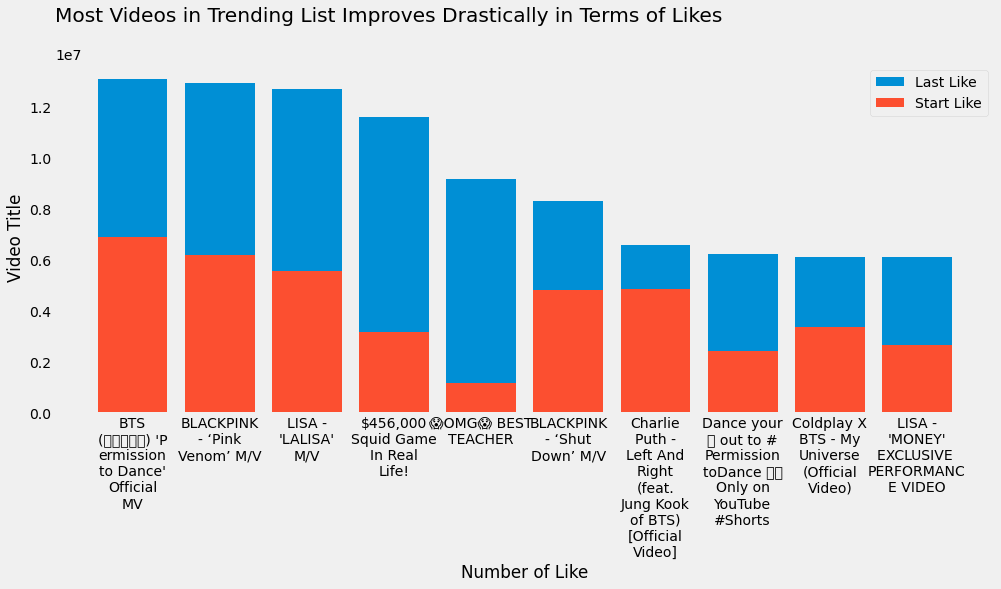

In [ ]:
# Visualisasi Trending Video Teratas
# Visualisasi "Like"
top_10_liked = trending_rewind["like"].sort_values("max", ascending=False).iloc[:10]
plt.figure(figsize=(15, 6))
plt.bar(
 top_10_liked.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
 top_10_liked["max"],
 label="Last Like"
)
plt.bar(
 top_10_liked.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
 top_10_liked["min"],
 label="Start Like"
)
plt.title("Most Videos in Trending List Improves Drastically in Terms of Likes", loc="left", y=1.1)
plt.xlabel("Number of Like")
plt.ylabel("Video Title")
plt.legend()
plt.grid(False)
plt.show()

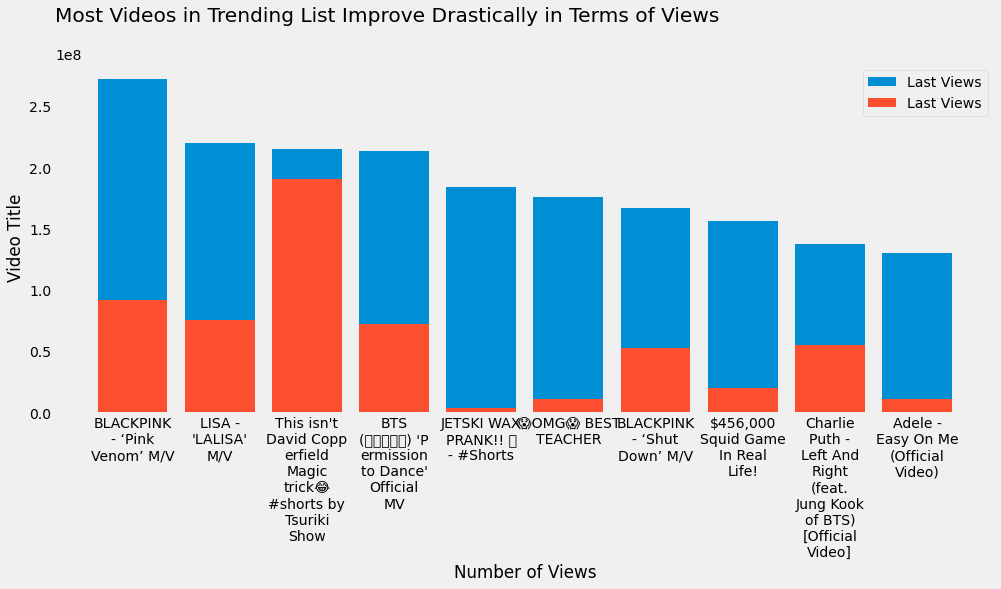

In [ ]:
# Visualisasi "View"
top_10_viewed = trending_rewind["view"].sort_values("max", ascending=False).iloc[:10]

plt.figure(figsize=(15, 6))
plt.bar(
    top_10_viewed.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_viewed["max"],
    label="Last Views"
)
plt.bar(
    top_10_viewed.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_viewed["min"],
    label="Last Views"
)
plt.title("Most Videos in Trending List Improve Drastically in Terms of Views", loc="left", y=1.1)
plt.xlabel("Number of Views")
plt.ylabel("Video Title")
plt.legend()
plt.grid(False)
plt.show()

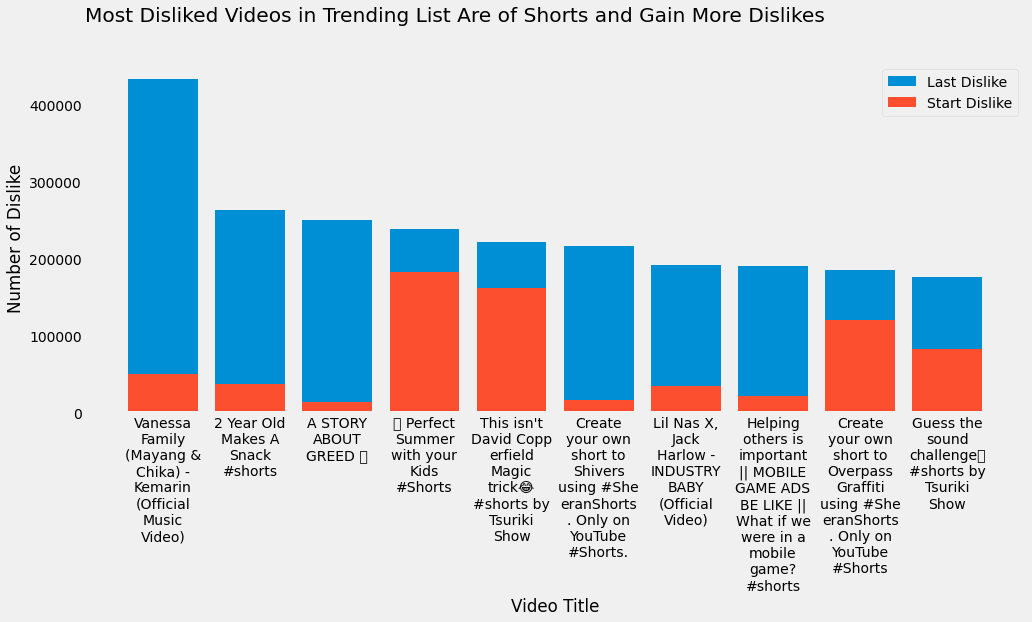

In [ ]:
# Visualisasi "Dislike"
top_10_disliked = trending_rewind["dislike"].sort_values("max", ascending=False).iloc[:10]
plt.figure(figsize=(15, 6))
plt.bar(
 top_10_disliked.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
 top_10_disliked["max"],
 label="Last Dislike"
)
plt.bar(
 top_10_disliked.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
 top_10_disliked["min"],
 label="Start Dislike"
)
plt.title("Most Disliked Videos in Trending List Are of Shorts and Gain More Dislikes", loc="left", y=1.1)
plt.ylabel("Number of Dislike")
plt.xlabel("Video Title")
plt.legend()
plt.grid(False)
plt.show()

In [ ]:
# Attention
# Sebagai contoh, perhatikan sampel judul dan deskripsi video berikut
sample = filtered_trending.sample(10, random_state=11)
sample[["title", "description"]]

,title,description
52095,MINGWEIROCKS - The FASTEST way to make M&Ms! #...,"Hey people! 💛 If you enjoyed this video, remem..."
46656,RAHASIA GEL4P MODEL DAN BOSS VICTORIA'S SECRET,kalo mau beli tube light: https://instagram.co...
111071,Crystal Palace 1-2 Chelsea | Premier League Hi...,Victory at Selhurst Park over Crystal Palace. ...
33483,[주간아 미방] 스트레이키즈(Stray Kids) '소리꾼(THUNDEROUS)’ ...,[주간아이돌 4K 직캠]\n스트레이키즈 - 소리꾼\nStray Kids - THUN...
51494,PERSIAPAN PULANG KE INDONESIA! BELI OLEH2 DAN ...,Konnijiwa! Di video kali ini aku dan Lukas mau...
97352,j-hope 'MORE' Official MV,j-hope 'MORE' Official MV\n\nCredits:\nProduct...
38316,Goals everywhere 🥵 | Highlights Ajax - SC Camb...,Na het Europese succes tegen Sporting nam Ajax...
98196,DENNY CAKNAN FT YENI INKA - ALUN ALUN NGANJUK ...,#DCMUSIK #DCPRODUCTION\n\nTitle: ALUN ALUN NGA...
49344,TANTANG KATAK BIZHER DI JALUR TRAIL !! O5PEK S...,Siapa yang gatau Katak Bizher ini dia si raja ...
55562,Cidro 3,Provided to YouTube by Believe SAS\n\nCidro 3 ...


In [ ]:
# Merubah judul dan deskripsi video menjadi lowercase
sample["title_lang"] = sample.title.apply(lambda title: langdetect.detect(title.lower()))
sample["desc_lang"] = sample.description.apply(lambda desc: langdetect.detect(desc.lower()))

In [ ]:
with pd.option_context("display.max_colwidth", 100):
 display(sample[["title", "title_lang", "description", "desc_lang"]])

,title,title_lang,description,desc_lang
52095,MINGWEIROCKS - The FASTEST way to make M&Ms! #shorts,en,"Hey people! 💛 If you enjoyed this video, remember to give it a great big thumbs up and SUBSCRIBE...",en
46656,RAHASIA GEL4P MODEL DAN BOSS VICTORIA'S SECRET,ca,kalo mau beli tube light: https://instagram.com/sinarphoto?utm_medium=copy_link\n\nmau beli baju...,id
111071,Crystal Palace 1-2 Chelsea | Premier League Highlights,en,Victory at Selhurst Park over Crystal Palace. Two minute highlights of another tough London derb...,en
33483,[주간아 미방] 스트레이키즈(Stray Kids) '소리꾼(THUNDEROUS)’ 4K 직캠 l EP.526,vi,[주간아이돌 4K 직캠]\n스트레이키즈 - 소리꾼\nStray Kids - THUNDEROUS\n\n#주간아이돌 #스트레이키즈 #소리꾼,vi
51494,PERSIAPAN PULANG KE INDONESIA! BELI OLEH2 DAN HADIAH BUAT SURPRISE KELUARGA!!,id,Konnijiwa! Di video kali ini aku dan Lukas mau persiapan buat pulang ke Indonesia setelah 2 tahu...,id
97352,j-hope 'MORE' Official MV,en,j-hope 'MORE' Official MV\n\nCredits:\nProduction : Boring Studio\nDirector : Lee Suho \nCreativ...,en
38316,Goals everywhere 🥵 | Highlights Ajax - SC Cambuur | Eredivisie,en,Na het Europese succes tegen Sporting nam Ajax het in de Johan Cruijff Arena op tegen Cambuur. H...,nl
98196,DENNY CAKNAN FT YENI INKA - ALUN ALUN NGANJUK (OFFICIAL LIVE MUSIC) - DC MUSIK,id,#DCMUSIK #DCPRODUCTION\n\nTitle: ALUN ALUN NGANJUK\nVoc : DENNY CAKNAN FT YENI INKA\nCipt : NDAR...,id
49344,TANTANG KATAK BIZHER DI JALUR TRAIL !! O5PEK SAMPE K4P0K ?!,id,Siapa yang gatau Katak Bizher ini dia si raja Jalanan!\n♛ FOLLOW MY INSTAGRAM:\nhttps://instagra...,en
55562,Cidro 3,pt,Provided to YouTube by Believe SAS\n\nCidro 3 · Jihan Audy · Faried Davidson · Faried Davidson\n...,en


In [ ]:
# Deteksi Bahasa Untuk Semua Video
# Pertama, kita akan buat fungsi yang akan mendeteksi bahasa dari sebuah teks sebagai berikut.
def detect_language(text):
 """Detect language of the `text`."""
 try: 
  lang = langdetect.detect(text)
  return lang
 except:
  return

In [ ]:
filtered_trending["title_lang"] = filtered_trending["title"].apply(detect_language)
filtered_trending["desc_lang"] = filtered_trending["description"].apply(detect_language)

In [ ]:
filtered_trending[["title", "title_lang", "description", "desc_lang"]]

,title,title_lang,description,desc_lang
21322,NCT DREAM 엔시티 드림 'Hello Future' MV,it,"NCT DREAM's 1st Album Repackage ""Hello Future""...",en
21323,PART 3 // SUTRISNO DAN ENDANG BAHAGIA,de,Find me on sosial media :\n\nInstagram : https...,en
21324,This isn't David Copperfield Magic trick😂 #sho...,en,Thank you for watching.\nSubscribe to Tsuriki ...,en
21325,Rizky Billar - Pemimpinmu | Official Music Video,en,Rizky Billar - Pemimpinmu | Official Music Vid...,id
21326,Ini Pengakuan Pengemudi Pajero usai Rusak dan ...,id,Polisi menangkap pengemudi SUV yang merusak da...,id
...,...,...,...,...
118946,Aku Mengecilkan Badan Ku untuk ISENGIN Temen k...,id,WKWK GUE KECILIN BADAN GUA BUAT ISENGIN TEMEN ...,id
118947,Brunei Darussalam 6-2 Timor-Leste (#AFFMitsubi...,en,🎥 HLs | 🇧🇳 Brunei DS 6️⃣-2️⃣ Timor-Leste 🇹🇱\n\...,en
118948,TUKANG BAKSO NAIK HAJI❤️,vi,TUKANG BAKSO NAIK HAJI❤️,vi
118949,KACAU NIH BAKSO.. KALIAN GAK AKAN NYANGKA KALA...,de,Bakso loncat pak sabit\nAlamat: Gg. Kong Koan ...,id


In [ ]:
# Buang data video yang judul atau deskripsi berbahasa asing
indo_trending = filtered_trending.loc[
 (filtered_trending.title_lang == "id") | (filtered_trending.desc_lang == "id")
]
with pd.option_context("display.max_columns", None):
 display(indo_trending.sample(10))

,video_id,publish_time,channel_id,title,description,thumbnail_url,thumbnail_width,thumbnail_height,channel_name,tags,category_id,live_status,local_title,local_description,duration,dimension,definition,caption,license_status,allowed_region,blocked_region,view,like,dislike,favorite,comment,trending_time,title_lang,desc_lang
22850,NaN,2021-07-07 15:50:01+00:00,UC24_Z2L-8Ki183AI9zJJzNQ,IKLANNYA AJA UDAH BIKIN KETAWA! | LAPOR PAK! (...,Emang cuma di Lapor Pak yang mau ngiklan tapi ...,NaN,NaN,NaN,TRANS7 OFFICIAL,"['TRANS7', 'TRANSMEDIA', '#StayHome', '#WithMe...",24,none,IKLANNYA AJA UDAH BIKIN KETAWA! | LAPOR PAK! (...,Emang cuma di Lapor Pak yang mau ngiklan tapi ...,PT15M25S,2d,hd,False,True,NaN,NaN,308588.0,6925.0,150.0,0,582.0,2021-07-08 06:08:48.449771+00:00,en,id
115018,ZhyD6_Otwik,2022-10-25 15:30:14+00:00,UC3J4Q1grz46bdJ7NJLd4DGw,Boss Besar Tertangkap - Call Of Duty Modern Wa...,Misi kita dalam menyelamatkan Laswell berhasil...,https://i.ytimg.com/vi/ZhyD6_Otwik/hqdefault.jpg,480.0,360.0,MiawAug,"['MiawAug', 'Call Of Duty', 'COD', 'Call Of Du...",20,none,Boss Besar Tertangkap - Call Of Duty Modern Wa...,Misi kita dalam menyelamatkan Laswell berhasil...,PT41M35S,2d,hd,False,True,NaN,NaN,504575.0,24548.0,NaN,0,1108.0,2022-11-01 06:01:28.735878+00:00,id,id
105737,8GgO_SJSv6w,2022-08-25 12:00:14+00:00,UCJhYZjeQG25rDmevmy4szMw,James AP Ft. Fida - TEPUNG KANJI 2 (AMBYAARR L...,"Live Version by James AP ft Fida ""TEPUNG KANJI...",https://i.ytimg.com/vi/8GgO_SJSv6w/hqdefault.jpg,480.0,360.0,James AP,"['Fida', 'James AP', 'TEPUNG KANJI 2', 'Satru ...",10,none,James AP Ft. Fida - TEPUNG KANJI 2 (AMBYAARR L...,"Live Version by James AP ft Fida ""TEPUNG KANJI...",PT5M57S,2d,hd,False,True,NaN,NaN,1279589.0,26303.0,NaN,0,2408.0,2022-09-15 06:01:31.320739+00:00,de,id
96271,J7wPfcpRhSg,2022-06-29 12:00:12+00:00,UCcSVA15A6UNouOvHsixy1ng,TIARA - Kris (Jika Kau Bertemu Aku Begini) - T...,Official Music Video from Tasya Rosmala Ft.Ger...,https://i.ytimg.com/vi/J7wPfcpRhSg/hqdefault.jpg,480.0,360.0,PERDANA RECORD,['TIARA (Jika Kau Bertemu Aku Begini) - Tasya ...,10,none,TIARA - Kris (Jika Kau Bertemu Aku Begini) - T...,Official Music Video from Tasya Rosmala Ft.Ger...,PT6M42S,2d,hd,True,True,NaN,NaN,3023840.0,30441.0,NaN,0,5252.0,2022-07-29 06:01:07.379261+00:00,id,id
104924,_skGIgFxPJM,2022-08-29 07:15:11+00:00,UCaKLg1ELiX0zTJ6Je3c5esA,borong Supermarket makanan ameena pertama kali...,"Instagram : @attahalilintar , @aurelie.hermans...",https://i.ytimg.com/vi/_skGIgFxPJM/hqdefault.jpg,480.0,360.0,AH,NaN,24,none,borong Supermarket makanan ameena pertama kali...,"Instagram : @attahalilintar , @aurelie.hermans...",PT8M24S,2d,hd,False,True,NaN,NaN,753177.0,37400.0,NaN,0,2575.0,2022-09-11 06:02:20.153431+00:00,id,id
95744,EbAY5RyzOV8,2022-06-30 03:35:20+00:00,UC8qp0ZmavLOGeSdLxSUZO8w,OPW ARES Sudah Tamat,Join Membership : \nhttps://www.youtube.com/c...,https://i.ytimg.com/vi/EbAY5RyzOV8/hqdefault.jpg,480.0,360.0,BUDI01 GAMING,"['budi01gaming', 'budi01']",20,none,OPW ARES Sudah Tamat,Join Membership : \nhttps://www.youtube.com/c...,PT11M39S,2d,hd,False,True,NaN,NaN,1753533.0,161283.0,NaN,0,31688.0,2022-07-26 06:05:58.416968+00:00,id,en
98062,KX1kFL2KOW0,2022-07-24 10:00:10+00:00,UCwXPLUOgfDRdDuDQup-mWNQ,VIRAL! SAMBAL BAKAR IBEN NGANTRI SAMPE 3JAM!!!...,"Sambal Bakar, Tangerang\nAlamat : Jl. Veteran ...",https://i.ytimg.com/vi/KX1kFL2KOW0/hqdefault.jpg,480.0,360.0,Gerry Girianza,"['sambal bakar', 'sambal', 'ayam geprek', 'aya...",22,none,VIRAL! SAMBAL BAKAR IBEN NGANTRI SAMPE 3JAM!!!...,"Sambal Bakar, Tangerang\nAlamat : Jl. Veteran ...",PT21M16S,2d,hd,False,True,NaN,NaN,638987.0,14496.0,NaN,0,292.0,2022-08-08 06:01:51.309705+00:00,de,id
39783,NaN,2021-09-23 15:15:03+00:00,UCU_fuBEbZ0Wcf3ZNWEtxwzg,"Tantang Ayah Taqy Malik Bersumpah, Marlina: Di...",Tanggal Tayang: 23/09/2021\n\nDuri Dalam Rumah...,NaN,NaN,NaN,Hotman Paris Show,"['iNews', 'Hotman Paris Show', 'iNews TV', 'Ho...",24,none,"Tantang Ayah Taqy Malik Bersumpah, Marlina: Di...",Tanggal Tayan

In [ ]:
# Feature Extraction
# Buang semua fitur/kolom yang tidak diperlukan, hanya menyisakan judul, deskripsi dan id kategori
data = indo_trending[["title", "description", "category_id"]].reset_index(drop=True)
data

,title,description,category_id
0,Rizky Billar - Pemimpinmu | Official Music Video,Rizky Billar - Pemimpinmu | Official Music Vid...,10
1,Ini Pengakuan Pengemudi Pajero usai Rusak dan ...,Polisi menangkap pengemudi SUV yang merusak da...,25
2,Aksi Demo Tolak Kedatangan Jokowi di Kendari B...,Tanggal Tayang: 30/06/2021\n\nProgram berita h...,25
3,"PERTAMA KALI LIAT SAPI SEGEDE GINI, DINAIKIN D...",Assalamualaikum gaeess..! sudah nonton video s...,15
4,PODKESMAS SAMPAI GA NYAMAN DIBAHAS DISINI - To...,Talk show malam yang akan memberikan informasi...,24
...,...,...,...
38134,"TERAKHIR UMROH MASIH DI DALEM PERUT MAMAH, SEK...",=================================\r\n\r\nSocia...,24
38135,HAPPY ASMARA - RUNGKAD Ft.BINTANG FORTUNA ( Of...,HAPPY ASMARA - RUNGKAD Ft.BINTANG FORTUNA ( Of...,22
38136,Aku Mengecilkan Badan Ku untuk ISENGIN Temen k...,WKWK GUE KECILIN BADAN GUA BUAT ISENGIN TEMEN ...,20
38137,KACAU NIH BAKSO.. KALIAN GAK AKAN NYANGKA KALA...,Bakso loncat pak sabit\nAlamat: Gg. Kong Koan ...,22


In [ ]:
# Duplicate
# Buang beberapa duplikat
data.drop_duplicates(subset="title", inplace=True)

In [ ]:
data.reset_index(drop=True, inplace=True)
data.shape

(6202, 3)

In [3]:
# Install Emoji
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 240 kB 4.8 MB/s 
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=b58b9d1912ad8d8cef2da862612b59ba8ec5303b67a9b4b5f0c07939f59dd087
  Stored in directory: /root/.cache/pip/wheels/f3/e3/f2/1de1c2e3ed742e1df73e0f15d58864e50c7e64f607b548d6cf
Successfully built emoji


In [6]:
# Feature Engineering
# Mencari judul video yang menggunakan emoji
list_emoji = [e for e in emoji.UNICODE_EMOJI.get("en")]

count = 0
for em in list_emoji:
  for title in data.title:
    if em in title:
      count += 1
print("How Many Titles Use Emoji?", count)

NameError: ignored

In [2]:
def demojize(text):
    for em in list_emoji:
        if em in text:
            em_text = emoji.demojize(em)
            text = text.replace(em, " " + em_text + " ")
    return text

In [ ]:
data["title_emoji"] = data.title.apply(demojize)

NameError: ignored